As pointed out by Luis, it would be nice to have a simple API to:
- load the data so that rows are genomic intervals rather than individual RNAs. That way we would be able to work with square matrices where the rows and columns correspond to the same genomic regions
- fetch specific regions on the rows, the columns, or both in combination (as in pairix)

Here, we look at the current ways we can do that with the existing code. It would be nice to incorporated some dedicated functions in chartools. 

In the last section, we can see that we can load our dataset via the .pairs file directly into a cooler object. It would awesome to have a way to interconvert between pairix object and a chartable.

In [17]:
from charmodels.prepare_data.RDloader import load_RD_data
import pandas as pd
from chartools import charcounter as cc

In [2]:
chardata=load_RD_data(cleaned_up=True, loadrna=False, loaddna=True, loadbkg=False, loadmodels=False)

5it [00:05,  1.16s/it]                                            


In [93]:
from chartools import plotter as trtools #trtools = Track Tools

In [94]:
intervals = trtools.get_intervals(['chr8','chr9','chr10'], binsize=1000000) # maybe that function exists already in bioframe?

In [95]:
intervals

,chr,start,stop,name
1395,chr8,0,1000000,0
1396,chr8,1000000,2000000,1
1397,chr8,2000000,3000000,2
1398,chr8,3000000,4000000,3
1399,chr8,4000000,5000000,4
...,...,...,...,...
1809,chr10,129000000,130000000,414
1810,chr10,130000000,131000000,415
1811,chr10,131000000,132000000,416
1812,chr10,132000000,133000000,417


In [18]:
dna = chardata['dna']['ES']['all']

In [19]:
pr = dna.df_to_shelf(intervals.sort_values(['chr','start']), feature_info_id='name')

In [21]:
dna_binned = dna.project(pr)
chrnat = ['chr%g'%k for k in range(1,23)]+['chrX']
dna_binned, _ = dna_binned.reindex_chr(chrnat) #put chromosomes in natural order

In [23]:
dna_binned.chr_blocks

array([  0,   0,   0,   0,   0,   0,   0,   0, 146, 285, 419, 419, 419,
       419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419])

In [25]:
intervals

,chr,start,stop,name
1395,chr8,0,1000000,0
1396,chr8,1000000,2000000,1
1397,chr8,2000000,3000000,2
1398,chr8,3000000,4000000,3
1399,chr8,4000000,5000000,4
...,...,...,...,...
1809,chr10,129000000,130000000,414
1810,chr10,130000000,131000000,415
1811,chr10,131000000,132000000,416
1812,chr10,132000000,133000000,417


# Select columns within region

How to select columns for chr9:1.5M to 5.5M?

Method 1: create a new projector

In [26]:
myregion = trtools.get_intervals('chr9', start=1.5e6, stop=5.5e6, binsize=1000000)
dna_columns_within_region,_ = dna.project(dna.df_to_shelf(myregion, feature_info_id='name')).reindex_chr(chrnat)

Method 2: filter bins

In [32]:
intervals.head()

,chr,start,stop,name
1395,chr8,0,1000000,0
1396,chr8,1000000,2000000,1
1397,chr8,2000000,3000000,2
1398,chr8,3000000,4000000,3
1399,chr8,4000000,5000000,4


We want the name of the bins within region. Note that there is some approximation as we pick only bins that completely overlap with the region of interest. 

In [45]:
intervals_to_select = intervals.loc[(intervals['chr']=='chr9') & (intervals['start']>=1.5e6)  & (intervals['stop']<=5.5e6)]   
intervals_to_select

,chr,start,stop,name
1543,chr9,2000000,3000000,148
1544,chr9,3000000,4000000,149
1545,chr9,4000000,5000000,150


In [44]:
dna_columns_within_region_v2 = dna_binned.select_bins(intervals_to_select['name'].values)

As expected, the resulting chartable only has only 3 columns

In [97]:
dna_columns_within_region_v2.counts

<41238x3 sparse matrix of type '<class 'numpy.int64'>'
	with 17586 stored elements in Compressed Sparse Row format>

We might want to make a high level function for that?

## Select genes within regions

In [41]:
genes = chardata['genes']

First this functions picks the genes that fall within the intervals of intersest

In [49]:
def get_genes_in_intervals(intervals):
    genes_in_intervals = [genes.loc[(genes['chr']==chro) & (genes['stop']>=start) & (genes['start']<=stop)].index.to_list() for chro, start, stop in zip(intervals['chr'],intervals['start'], intervals['stop'])]
    
    
    return genes_in_intervals

In [98]:
intervals_to_select

,chr,start,stop,name
1543,chr9,2000000,3000000,148
1544,chr9,3000000,4000000,149
1545,chr9,4000000,5000000,150


In [52]:
get_genes_in_intervals(intervals_to_select) # returns list of list, item#i in the outer list is the list of all the genes falling into interval #i. 

[['ENSG00000080503.23',
  'ENSG00000236199.1',
  'ENSG00000222973.1',
  'ENSG00000264615.2',
  'ENSG00000236404.9',
  'ENSG00000231052.1',
  'ENSG00000147852.15',
  'ENSG00000168263.8',
  'ENSG00000080608.9',
  'ENSG00000236496.2',
  'ENSG00000229184.2',
  'ENSG00000227835.8'],
 ['ENSG00000227835.8',
  'ENSG00000236511.1',
  'ENSG00000080298.15',
  'ENSG00000215297.3',
  'ENSG00000232104.3',
  'ENSG00000237359.1',
  'ENSG00000226669.2',
  'ENSG00000107249.22',
  'ENSG00000236724.1',
  'ENSG00000237009.2'],
 ['ENSG00000107249.22',
  'ENSG00000230001.1',
  'ENSG00000228322.1',
  'ENSG00000200941.1',
  'ENSG00000106688.11',
  'ENSG00000106686.16',
  'ENSG00000225893.1',
  'ENSG00000205808.5',
  'ENSG00000273061.1',
  'ENSG00000106993.11',
  'ENSG00000147853.16',
  'ENSG00000270639.1',
  'ENSG00000220105.2',
  'ENSG00000120158.11',
  'ENSG00000233186.2',
  'ENSG00000199065.3',
  'ENSG00000228165.1',
  'ENSG00000220937.3',
  'ENSG00000096968.13']]

Now the next function will create an accumulation matrix (transfer_matrix) to sum up the rows corresponding to each set of genes in that list. The matrix looks ok but I haven't updated annot_LUT and annot_chr (should be something like ['chr9_2000000_3000000', 'chr9_3000000_4000000', ...] and ['chr9','chr9', ...]

In [67]:
import numpy as np
from scipy import sparse as sp

def select_rows_bygroups(data, grps, grp_names = None):
    
    ngrps = len(grps)
    transfer_indptr = np.zeros(ngrps+1, int)
    transfer_indices = np.empty([0], int)
    
    out=data.copy(copydata=False)
    
    n = 0

    for i, g in enumerate(grps):
        transfer_indptr[i] = n
        
        annots_ixs = np.array([data.annot_dict.get(k, -1) for k in g], dtype=int)
        annots_ixs = np.sort(annots_ixs[annots_ixs>=0])
        
        
        n_in_grp = len(annots_ixs)
        
        if n_in_grp>0:
            n += n_in_grp
            transfer_indices = np.append(transfer_indices, annots_ixs)
        
        transfer_indptr[i+1] = n
    
    transfer_data = np.ones(n, int)
        
    annot_select=sp.csr_matrix((transfer_data, transfer_indices, transfer_indptr), shape=(ngrps, len(data.annot_LUT)))
    
    
    out.counts=(annot_select*data.counts)
    out.counts.eliminate_zeros()
        
    out.annot_dict={ix:ix for ix, _ in enumerate(grps)} #right nw just indices, may implement group names
    out.nannot=ngrps
    out.annot_LUT=[ix for ix in range(len(grps))] #annots.copy()
        
        
    out.annot_chr=[] #needs implementation
    #genes['chr'].loc[annots].copy().map(self.chr_dict).values #annots_chr_id.copy()
        
    return(out)


    

Putting everything together

In [71]:
data_binned_square = select_rows_bygroups(dna_columns_within_region_v2, get_genes_in_intervals(intervals_to_select))

As expected, we get a square matrix

In [72]:
data_binned_square.counts

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

# Direct data loading with cooler

First make cooler file. Note that we use asymetric definitions of chromosomes for RNA and DNA side. RNA preceded by R_ to make the pairix file lower triangle (R_chr.. always greater in C order that chr..)

In [76]:
!cat /scratch/groups/astraigh/charseq_main_data/resources/chrNameLength_1-22X_withRNA.sorted.txt

chr1	248956422
chr10	133797422
chr11	135086622
chr12	133275309
chr13	114364328
chr14	107043718
chr15	101991189
chr16	90338345
chr17	83257441
chr18	80373285
chr19	58617616
chr2	242193529
chr20	64444167
chr22	50818468
chr3	198295559
chr4	190214555
chr5	181538259
chr6	170805979
chr7	159345973
chr8	145138636
chr9	138394717
chrX	156040895
R_chr1	248956422
R_chr10	133797422
R_chr11	135086622
R_chr12	133275309
R_chr13	114364328
R_chr14	107043718
R_chr15	101991189
R_chr16	90338345
R_chr17	83257441
R_chr18	80373285
R_chr19	58617616
R_chr2	242193529
R_chr20	64444167
R_chr22	50818468
R_chr3	198295559
R_chr4	190214555
R_chr5	181538259
R_chr6	170805979
R_chr7	159345973
R_chr8	145138636
R_chr9	138394717
R_chrX	156040895


In [ ]:
%bash

cd /scratch/groups/astraigh/charseq_main_data/libraries/novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun/data/TFONM2_ES/pairs/gencondeV29_hg38/all

cooler cload pairix -p 4 /scratch/groups/astraigh/charseq_main_data/resources/chrNameLength_1-22X_withRNA.sorted.txt:1000000 /oak/stanford/groups/astraigh/differentiation_paper_data/charles/libraries/novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun/data/TFONM2_ES/pairs/gencondeV29_hg38/all/rd.CLEAN.indexed.pairs.gz ./rd.CLEAN.1Mbp.cool
    
    

In [77]:
import cooler

In [82]:
filepathRD = '/scratch/groups/astraigh/charseq_main_data/libraries/novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun/data/TFONM2_ES/pairs/gencondeV29_hg38/all/rd.CLEAN.1Mbp.cool'
clr = cooler.Cooler(filepathRD)



In [90]:
matRD = cRD.matrix(balance=False, sparse=True)[:]
matRD

<5994x5994 sparse matrix of type '<class 'numpy.int32'>'
	with 12683120 stored elements in COOrdinate format>

In [87]:
import matplotlib.pyplot as plt


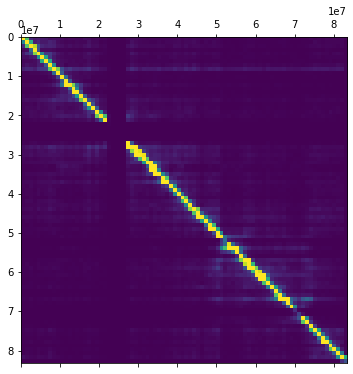

In [89]:
%matplotlib inline
f, axs = plt.subplots(
    figsize=(6,6),
    ncols=1)

im = axs.matshow(
    clr.matrix(balance=False).fetch('R_chr17', 'chr17'),
    vmax=2500,
    extent=(0,clr.chromsizes['R_chr17'], clr.chromsizes['chr17'], 0))